<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 6</h1>

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.datasets import load_iris
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, fmin, Trials, rand
from tensorflow.keras import layers, activations

from keras.layers import Input, Flatten, Dense

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Early stopping</h1>

Contenuto del dataframe
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

   

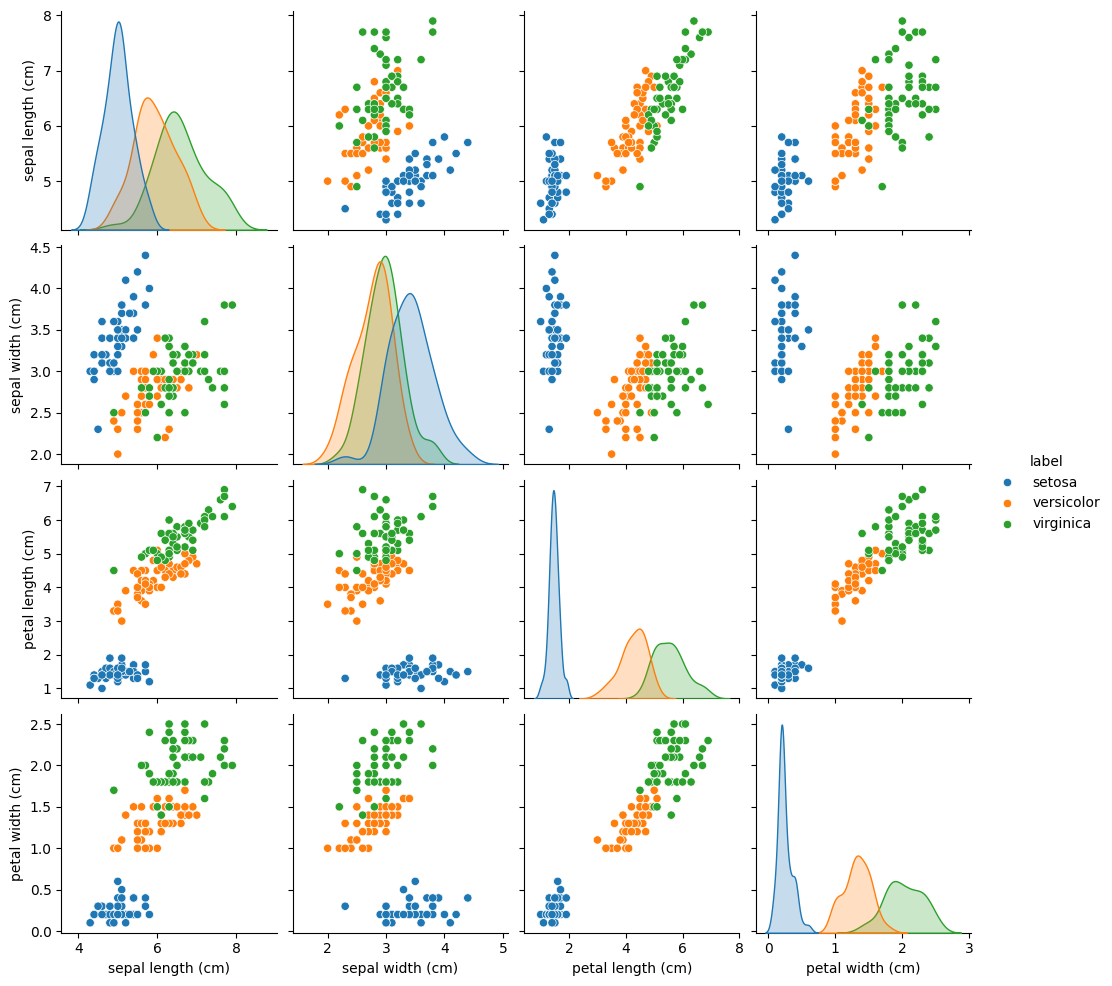

/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.4019 - loss: 1.0224 - val_accuracy: 0.5208 - val_loss: 0.9358
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6046 - loss: 0.8975 - val_accuracy: 0.7083 - val_loss: 0.8266
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6801 - loss: 0.8059 - val_accuracy: 0.7083 - val_loss: 0.7053
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7105 - loss: 0.6843 - val_accuracy: 0.7292 - val_loss: 0.5945
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7326 - loss: 0.5888 - val_accuracy: 0.9167 - val_loss: 0.4903
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8611 - loss: 0.4738 - val_accuracy: 0.8958 - val_loss: 0.3905
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8446 - loss: 0.4119 - val_accuracy: 0.9167 - val_loss: 0.3269
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8038 - loss: 0.3378 - val_accuracy: 0.9583 - val_loss

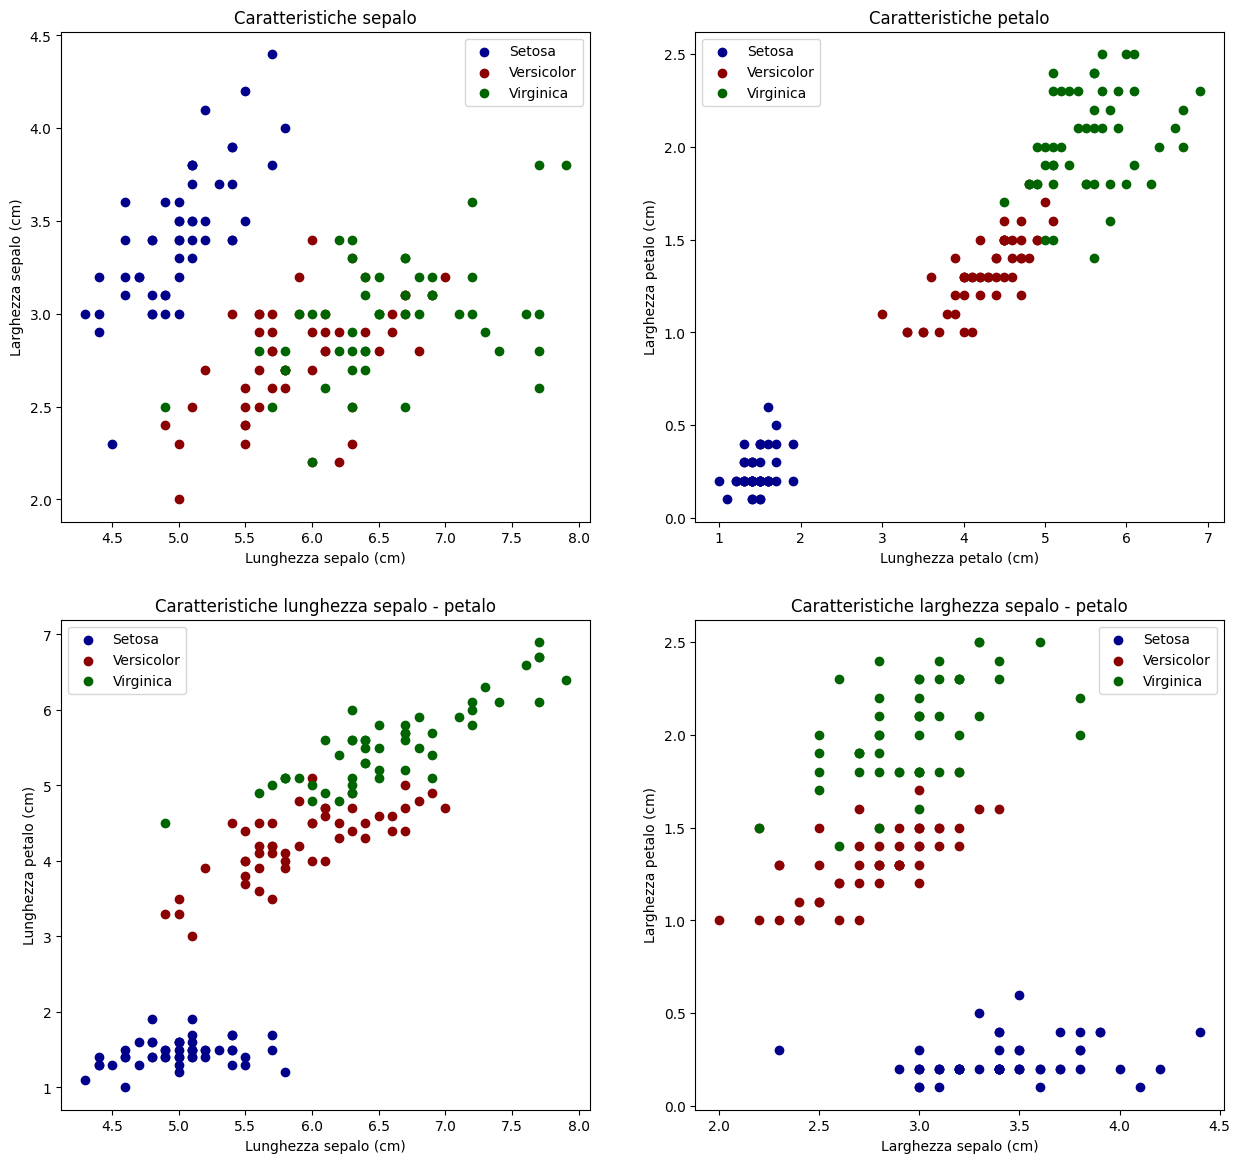

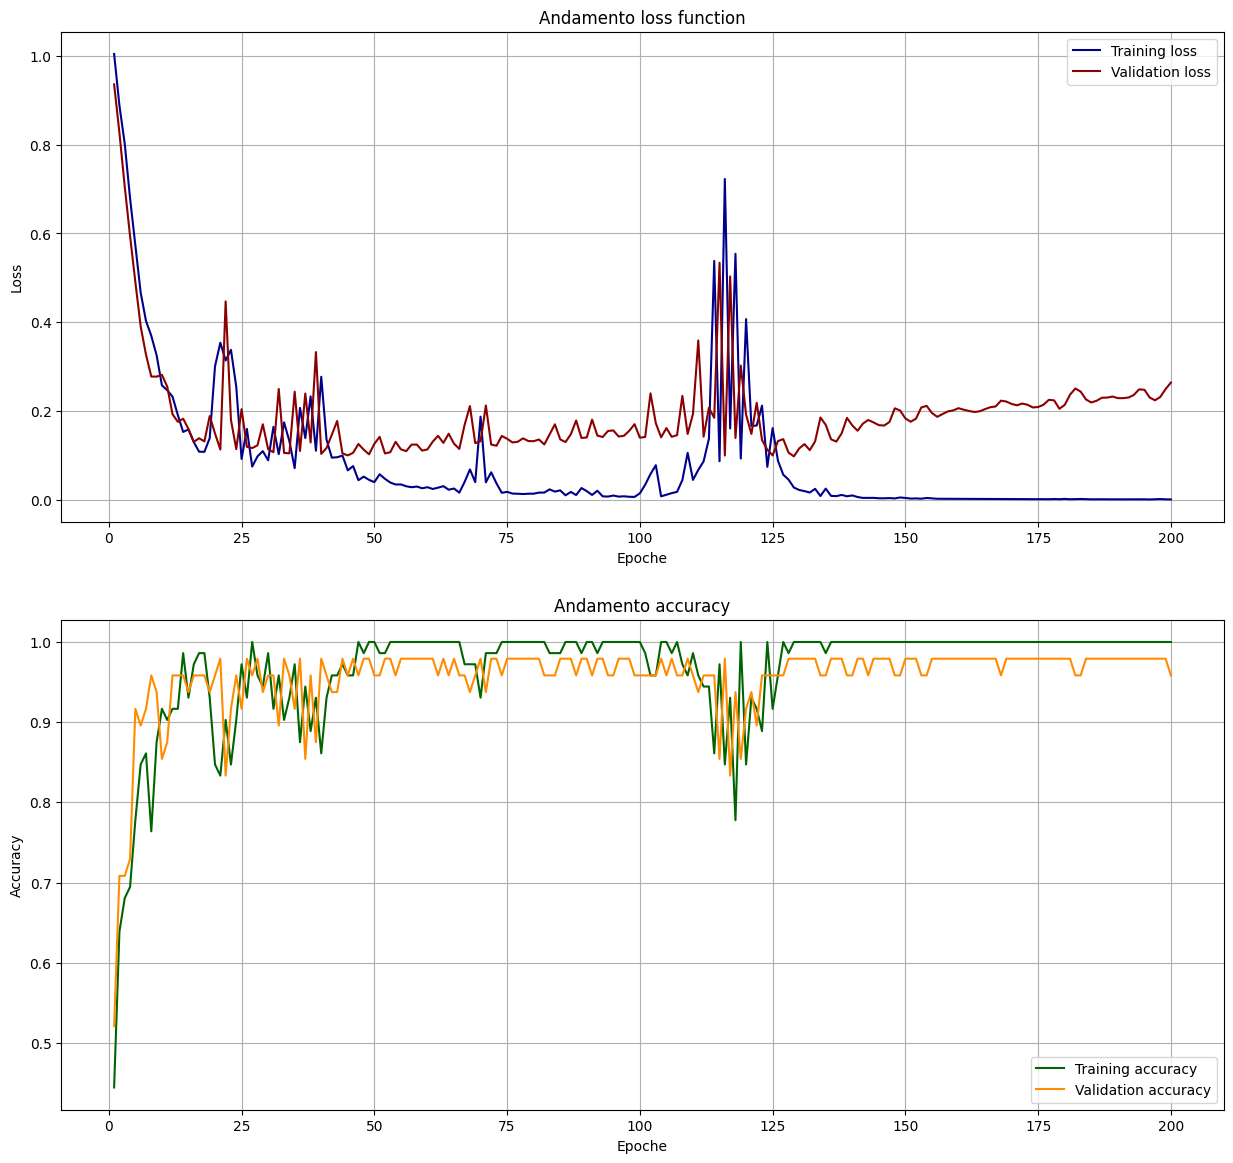

In [35]:
def stampaCorr(asc, ord, titx, tity, titp):
    # Funzione per stampare eventuali correlazioni presenti nel dataset
    fig, ax = plt.subplots(2, 2, figsize = (15, 14))

    # Doppio ciclo per riempire tutti i plot
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 0], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 0], color = 'darkblue', label  = "Setosa")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 1], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 1], color = 'darkred', label  = "Versicolor")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 2], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 2], color = 'darkgreen', label  = "Virginica")
            ax[i][j].set_xlabel(titx[2*i+j])
            ax[i][j].set_ylabel(tity[2*i+j])
            ax[i][j].set_title(titp[2*i+j])
            ax[i][j].legend(loc = 'best')


def studyDf(irisDf):
    # Funzione che fa uso del modulo seaborn, che è una libreria di visualizzazione dati
    # pensata per la visualizzazione grafica di dataset. In questo caso per andare a studiare le 
    # correlazioni fra le varie colonne basta usare il comando ".pairplot(...)" che genera una matrice
    # di scatter plot in cui ciascuna variabile numerica è messa in rapporto con le altre. Sono da fornire,
    #  come argomenti della funzione in questione il dataset da confrontare ed il fatto che i dati vengono 
    # colorati in base al valore della colonna 'label'
    sns.pairplot(irisDf, hue='label')
    plt.show()


# Creazione del modello. Dato che il problema che stiamo prendendo in considerazione è un 
# problema di classificazione, è necessario che i nodi di output siano tanti quanti sono le 
# classi del dataset in analisi. Per tali componenti della rete vogliamo utilizzare come funzione 
# d'attivazione 'softmax', in modo tale che sia possibile identificare quale sia la predizione più 
# probabile del modello.
def buildMod():
    # Funzione per creare il modello. Stiamo pensando di utilizzare un DNN con diversi layers nascosti 
    # in modo tale da rendere eccessivamente complicato il modello e poter lavorare con early stopping
    # techniques. Il layer di output conterrà tre soli nodi, per valutare quale sia la classe a cui 
    # appartiene con maggior probabilità il campione in analisi.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    return model


def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    ax[0].plot(np.linspace(1, 200, 200), hist.history['loss'], color = 'darkblue', label = "Training loss")
    ax[0].plot(np.linspace(1, 200, 200), hist.history['val_loss'], color = 'darkred', label = "Validation loss")
    ax[0].set_title("Andamento loss function")
    ax[0].set_xlabel("Epoche")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.linspace(1, 200, 200), hist.history['accuracy'], color = 'darkgreen', label = "Training accuracy")
    ax[1].plot(np.linspace(1, 200, 200), hist.history['val_accuracy'], color = 'darkorange', label = "Validation accuracy")
    ax[1].set_title("Andamento accuracy")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoche")

    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].grid(True)
    ax[1].grid(True)
    plt.show()


# La prima fase di questo esercizio consiste nell'importare il dataset IRIS, che
# restitusce un dizionario le cui flag sono:
#       - 'data': matrice con lughezze sepali e petali
#       - 'target': etichetta del fiore corrispondente
#       - 'feature_names': elenco di stringhe per nomi dati
#       - 'target_names': elenco di stringhe per nomi fiori
# In particolare 'data' è un array bidimensionale di forma (150, 4) in cui ogni riga
# rappresenta un fiore, e ogni colonna rappresenta una delle caratteristiche dello stesso. 
# Per ogni fiore sono quindi prese in considerazione 4 features, ossia lunghezza e larghezza
# del sepalo e del petalo.
iris = load_iris()
# Per convertire quanto ottenuto come output della funzione load_iris() in un oggetto di pandas 
# (che è comodo per gestiri tali tipologie di dataset) è possibile specificare nel costruttore 
# del dataFrame i dati contenuti in iris (ossia lunghezza e larghezza di sepali e petali di ciascun 
# fiore) ed i nomi delle colonne.
irisDf = pd.DataFrame(data = iris.data, columns = iris.feature_names)
# In un secondo momento vanno aggiunte delle altre colonne al dataframe, ossia l'etichetta numerica 
# target, che indica la classe di appartenenza del fiore, ed il nome della classe in questione.
# Questa operazione non può essere effettuata in fase di inizializzazione.

# Stampo a video il contenuto del dataset
irisDf['label'] = iris.target_names[iris.target]
print("Contenuto del dataframe")
print(irisDf)
studyDf(irisDf)

# Stampo a video eventuali correlazioni fra i dati del dataset individuate manualmente. Ciò che notiamo è 
# che la classificazione della classe setosa ci possiamo aspettare che sia più semplice rispetto alla 
# distinzione fra le altre due classi, poichè si notano degli evidenti cluster riferiti solo alla sottospecie setosa
# Convertiamo inoltre le labels per lavorare con one-hot encoding, ossia con tre colonne le quali presentano true o False
# per indicare o meno l'appartenenza a ciascuna delle tre classi
irisDf = pd.get_dummies(irisDf, columns=['label'], prefix='label')

asc = [0, 2, 0, 1]
ord = [1, 3, 2, 3]
titx = ["Lunghezza sepalo (cm)", "Lunghezza petalo (cm)", "Lunghezza sepalo (cm)", "Larghezza sepalo (cm)"]
tity = ["Larghezza sepalo (cm)", "Larghezza petalo (cm)", "Lunghezza petalo (cm)", "Larghezza petalo (cm)"]
titp = ["Caratteristiche sepalo", "Caratteristiche petalo", "Caratteristiche lunghezza sepalo - petalo", "Caratteristiche larghezza sepalo - petalo"]

stampaCorr(asc, ord, titx, tity, titp)


# Divido dataset in allenamento e validation, per poter allenare in modo adeguato il modello
# All'interno dei dati di training vado a selezionare quali sono gli input del modello e quali 
# invece gli output auspicabili
trainS = irisDf.sample(frac = 0.8, random_state=1)      # Seleziona 80% dataset
valS = irisDf.drop(trainS.index)                        # Identifica il restante 20%

# Per estrarre dati da dataframe pandas utilizzo il metodo iloc, che consente di lavorare con 
# indici riga ed indici colonna
trIn = trainS.iloc[:, 0:4]
trOut = trainS.iloc[:, 4:7]


# Definisco un modello e lo compilo utilizzando come ottimizzatore Adam ed invece come funzione di 
# perdita 'categorical_crossentropy'. Alleno la rete per 200 epoche utilizzando come dataset di validazione
# il 40 % del dataset di input. Questa tecnica viene utilizzata per ridurre l'overfitting ed è un buon approccio 
#  quando non si vuole fare uno split manuale dei dati, ma comunque è necessario monitorare le prestazioni del modello 
# su dati non visti durante l’allenamento
model = buildMod()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit( trIn, trOut, epochs=200, validation_split=0.4, batch_size=32,)
plotTrInfo(hist)